In [3]:
import numpy as np
import pandas as pd
import argparse
# import h5py
import pdb
from keras.preprocessing import sequence
from keras.utils import pad_sequences
import keras
from keras import backend as K
from keras.models import load_model

import tensorflow as tf
from tensorflow import keras 
import datetime, os
from tensorboard import notebook

from tensorflow.keras import models 
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
# loaded_model = load_model('./../CNN_results/model_final_t1.model')
loaded_model = load_model('./../CNN_results_split_final/Final_model.model')

model = loaded_model

2022-11-09 14:20:16.695868: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-11-09 14:20:16.695909: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-09 14:20:16.696283: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2500)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 2500, 20)     520         ['input_2[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 2500, 20)    0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 input_1 (InputLayer)           [(None, 2048)]       0           []                           

                                                                                                  
 batch_normalization_7 (BatchNo  (None, 128)         512         ['dense_2[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 activation_1 (Activation)      (None, 128)          0           ['batch_normalization_1[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 128)          0           ['batch_normalization_7[0][0]']  
                                                                                                  
 dropout_1 (Dropout)            (None, 128)          0           ['activation_1[0][0]']           
                                                                                                  
 dropout_2

In [6]:
from keras.utils import pad_sequences


seq_rdic = ['A','I','L','V','F','W','Y','N','C','Q','M','S','T','D','E','R','H','K','G','P','O','U','X','B','Z']
seq_dic = {w: i+1 for i,w in enumerate(seq_rdic)}


def encodeSeq(seq, seq_dic):
    if pd.isnull(seq):
        return [0] 
    else:
        return [seq_dic[aa] for aa in seq]
    
    
def prot_feature_gen_from_str_input(prot_input_str, prot_len = 2500):
    Prot_ID = prot_input_str.split(':')[0]
    Prot_seq = prot_input_str.split(':')[1]
    prot_dataframe = pd.DataFrame({'Protein_ID': Prot_ID, 'Sequence': Prot_seq}, index = [0])
    prot_dataframe.set_index('Protein_ID')
    
    
    prot_dataframe["encoded_sequence"] = prot_dataframe.Sequence.map(lambda a: encodeSeq(a, seq_dic))
    prot_feature = pad_sequences(prot_dataframe["encoded_sequence"].values, prot_len)
    
    return prot_feature, Prot_ID
    
    
KEGG_compound_read = pd.read_csv('./../CNN_data/Final_test/kegg_compound.csv', index_col = 'Compound_ID')
kegg_df = KEGG_compound_read.reset_index()
    
def mol_feature_gen_from_str_input(mol_str, kegg_id_flag):
	
	if kegg_id_flag == 1:
		KEGG_ID = mol_str
		kegg_id_loc = kegg_df.index[kegg_df.Compound_ID == KEGG_ID][0]
		KEGG_ID_info = kegg_df.loc[kegg_id_loc]
		KEGG_ID_info_df = KEGG_ID_info.to_frame().T.set_index('Compound_ID')
		
		final_return = KEGG_ID_info_df
		final_id = KEGG_ID
		
	else: 
		try:
			mol_ID = mol_str.split(':')[0]
			mol_smiles = mol_str.split(':')[1]
			mol = Chem.MolFromSmiles(mol_smiles)
			fp1 = AllChem.GetMorganFingerprintAsBitVect(mol, useChirality=True, radius=2, nBits=2048)
			fp_list = list(np.array(fp1).astype(float))
			fp_str = list(map(str, fp_list))
			mol_fp = '\t'.join(fp_str) 
			
			mol_dict = {}
			mol_dict['Compound_ID'] = mol_ID
			mol_dict['Smiles'] = mol_smiles
			mol_dict['morgan_fp_r2'] = mol_fp
			
			mol_info_df = pd.DataFrame(mol_dict, index=[0])
			mol_info_df = mol_info_df.set_index('Compound_ID')
			
			final_return = mol_info_df
			final_id = mol_ID
			
		except Exception as error:
			print('Something wrong with molecule input string...' + repr(error)) 
			
	return final_return, final_id
    
    
def act_df_gen_mol_feature(mol_id, prot_id):
	act_df = pd.DataFrame({'Protein_ID':prot_id, 'Compound_ID': mol_id}, index = [0])
	
	return act_df
	
	


def load_modelfile(model_string):
	loaded_model = tf.keras.models.load_model(model_string)
	return loaded_model
	


def model_prediction(compound_feature, enz_feature):
    prediction_vals = loaded_model.predict([compound_feature, enz_feature])
    
    return prediction_vals[0][0]


In [7]:
def compound_feature_gen_df_input(act_df, comp_df, comp_len = 2048, comp_vec= 'morgan_fp_r2'):
    act_df = pd.merge(act_df, comp_df, left_on='Compound_ID', right_index = True)
    comp_feature = np.stack(act_df[comp_vec].map(lambda fp: fp.split("\t")))
    comp_feature = comp_feature.astype('float')
    return comp_feature
    
    

In [8]:
def protein_feature_gen(prot_csv_file, prot_len = 2500):
    protein_df = pd.read_csv(prot_csv_file, index_col='Protein_ID')
    protein_df["encoded_sequence"] = protein_df.Sequence.map(lambda a: encodeSeq(a, seq_dic))
    pfeature = pad_sequences(protein_df["encoded_sequence"].values, prot_len)
    
    return pfeature, protein_df


def compound_feature_gen(act_csv_file, comp_csv_file, comp_len = 2048, comp_vec = 'morgan_fp_r2'):
    act_df = pd.read_csv(act_csv_file)
    comp_df = pd.read_csv(comp_csv_file, index_col = 'Compound_ID')
    act_df = pd.merge(act_df, comp_df, left_on='Compound_ID', right_index = True)
    comp_feature = np.stack(act_df[comp_vec].map(lambda fp: fp.split("\t")))
    comp_feature = comp_feature.astype('float')
    return comp_feature, act_df

In [9]:
# pstr = "A0A4P8WFA8:MTKRVLVTGGAGFLGSHLCERLLSEGHEVICLDNFGSGRRKNIKEFEDHPSFKVNDRDVRISESLPSVDRIYHLASRASPADFTQFPVNIALANTQGTRRLLDQARACDARMVFASTSEVYGDPKVHPQPETYTGNVNIRGARGCYDESKRFGETLTVAYQRKYDVDARTVRIFNTYGPRMRPDDGRVVPTFVTQALRGDDLTIYGDGEQTRSFCYVDDLIEGLISLMRVDNPEHNVYNIGKENERTIKELAYEVLGLTDTESDIVYEPLPEDDPGQRRPDITRAKTELDWEPKISLREGLEDTITYFDN"
# cstr = 'C00149'

pstr = 'g2p3t0:MTRDPEVVRLAVIPGDGIGPEVVAATVPTLRTALEAEGHRLDVASYDWGGERYLRQGAAMPADAAGLVKKADAVLFGAVGRPDVPEHELVWGLIIGLRQQLDLAVNLRPVRAFPGVPTKVRDTDGVDLVIVRENTEGEYVGAGGVAHAGSGHDLGIEVAVHSRRAIERAAHQAFALAGRRSGHLSLVTKSNAMRYGYPLWDRVVREVGEHYPAVRLETVLVDAMAARMIQAPRSLDVLLASNLFGDILSDLAAVLAGGMGMAPSANVLPGADVPGIYEPVHGSAPDIAGKGVANPVACMLSGAMLLDDLGHTGAARRVRDAVAATLRDVRHHTADLGGNATTAEVASAVLHTMESQG'
cstr = 'C00497'

pf, pid = prot_feature_gen_from_str_input(pstr)
cf, cid = mol_feature_gen_from_str_input(cstr, 1)
act_dataframe = act_df_gen_mol_feature(cid, pid)

cfeat = compound_feature_gen_df_input(act_dataframe, cf)

In [10]:
loaded_model.predict([cfeat, pf])

1/1 [==============================] - 1s 1s/step


array([[0.99448997]], dtype=float32)

In [11]:
Rule1_prot = pd.read_csv('./../CNN_data/Final_test/Rule_1_protein.csv', index_col='Protein_ID')
R1_act = pd.read_csv('./../CNN_data/Final_test/Rule_1_act_top_10_anal.csv')
R1_comp = pd.read_csv('./../CNN_data/Final_test/kegg_compound.csv', index_col = 'Compound_ID')


In [12]:
pfeature_R1, pdfr1 = protein_feature_gen('./../CNN_data/Final_test/Rule_1_protein.csv', prot_len=2500) 

In [13]:
cfeat_R1, act_dframe = compound_feature_gen('./../CNN_data/Final_test/Rule_1_act_top_10_anal.csv', './../CNN_data/Final_test/kegg_compound.csv', comp_len=2048, comp_vec='morgan_fp_r2')

In [14]:
pfeature_R1.shape

(2819, 2500)

In [74]:
act_dframe.head()

,Unnamed: 0_x,Protein_ID,Compound_ID,Unnamed: 0_y,smiles,morgan_fp_r2
0,0,P76251,C00497,103,O[C@H](CC(=O)[O-])C(=O)[O-],0.0\t1.0\t0.0\t0.0\t0.0\t0.0\t0.0\t0.0\t1.0\t0...
1,1,ECDH10B_1938,C00497,103,O[C@H](CC(=O)[O-])C(=O)[O-],0.0\t1.0\t0.0\t0.0\t0.0\t0.0\t0.0\t0.0\t1.0\t0...
2,2,BWG_1613,C00497,103,O[C@H](CC(=O)[O-])C(=O)[O-],0.0\t1.0\t0.0\t0.0\t0.0\t0.0\t0.0\t0.0\t1.0\t0...
3,3,ECMDS42_1474,C00497,103,O[C@H](CC(=O)[O-])C(=O)[O-],0.0\t1.0\t0.0\t0.0\t0.0\t0.0\t0.0\t0.0\t1.0\t0...
4,4,A0A6M7H0M6,C00497,103,O[C@H](CC(=O)[O-])C(=O)[O-],0.0\t1.0\t0.0\t0.0\t0.0\t0.0\t0.0\t0.0\t1.0\t0...


In [78]:
pid_r1 = act_dframe.Protein_ID.tolist()
cid_r1 = act_dframe.Compound_ID.tolist()

In [ ]:
loaded_model.summary()

In [15]:
prot_input_layer = loaded_model.get_layer('input_2')
embedding_1_layer = loaded_model.get_layer('embedding')
spatial_dropout1d_1_layer = loaded_model.get_layer('spatial_dropout1d')

mol_input_layer = loaded_model.get_layer('input_1')

conv1d_layer1 = loaded_model.get_layer('conv1d')
conv1d_layer2 = loaded_model.get_layer('conv1d_1')
conv1d_layer3 = loaded_model.get_layer('conv1d_2')
conv1d_layer4 = loaded_model.get_layer('conv1d_3')
conv1d_layer5 = loaded_model.get_layer('conv1d_4')

batch_normalization_p_conv_layer1 = loaded_model.get_layer('batch_normalization_2')
batch_normalization_p_conv_layer2 = loaded_model.get_layer('batch_normalization_3')
batch_normalization_p_conv_layer3 = loaded_model.get_layer('batch_normalization_4')
batch_normalization_p_conv_layer4 = loaded_model.get_layer('batch_normalization_5')
batch_normalization_p_conv_layer5 = loaded_model.get_layer('batch_normalization_6')

activation_p_conv_layer1 = loaded_model.get_layer('activation_2')
activation_p_conv_layer2 = loaded_model.get_layer('activation_3')
activation_p_conv_layer3 = loaded_model.get_layer('activation_4')
activation_p_conv_layer4 = loaded_model.get_layer('activation_5')
activation_p_conv_layer5 = loaded_model.get_layer('activation_6')


global_max_pooling1d_layer1 = loaded_model.get_layer('global_max_pooling1d')
global_max_pooling1d_layer2 = loaded_model.get_layer('global_max_pooling1d_1')
global_max_pooling1d_layer3 = loaded_model.get_layer('global_max_pooling1d_2')
global_max_pooling1d_layer4 = loaded_model.get_layer('global_max_pooling1d_3')
global_max_pooling1d_layer5 = loaded_model.get_layer('global_max_pooling1d_4')

concatenate_p_layers = loaded_model.get_layer('concatenate')
dense_layer_3 = loaded_model.get_layer('dense_2')
batch_normalization_p_layer8 = loaded_model.get_layer('batch_normalization_7')
activation_p_conv_layer8 = loaded_model.get_layer('activation_7')
dropout_p_layer = loaded_model.get_layer('dropout_2')



dense_layer_1_mol = loaded_model.get_layer('dense')
batch_normalization_c_layer1 = loaded_model.get_layer('batch_normalization')
activation_c_layer1 = loaded_model.get_layer('activation')
dropout_c_layer1 = loaded_model.get_layer('dropout')

dense_layer_2 = loaded_model.get_layer('dense_1')
batch_normalization_c_layer2 = loaded_model.get_layer('batch_normalization_1')
activation_c_layer2 = loaded_model.get_layer('activation_1')
dropout_c_layer2 = loaded_model.get_layer('dropout_1')


concatenate_layers_final = loaded_model.get_layer('concatenate_1')
dense_layer_final = loaded_model.get_layer('dense_3')
batch_normalization_layer_final = loaded_model.get_layer('batch_normalization_8')
activation_layer_final = loaded_model.get_layer('activation_8')
dense_layer_final_5 = loaded_model.get_layer('dense_4')
lambda_layer = loaded_model.get_layer('lambda')

In [16]:
model_prot_input_layer = tf.keras.models.Model([loaded_model.inputs],[prot_input_layer.output, loaded_model.output])
model_embedding_layer_1 = tf.keras.models.Model([loaded_model.inputs],[embedding_1_layer.output, loaded_model.output])
model_spatial_dropout1d_1_layer = tf.keras.models.Model([loaded_model.inputs],[ spatial_dropout1d_1_layer.output, loaded_model.output])

model_mol_input_layer = tf.keras.models.Model([loaded_model.inputs],[mol_input_layer.output, loaded_model.output])

model_conv1d_layer1 = tf.keras.models.Model([loaded_model.inputs],[conv1d_layer1.output, loaded_model.output])
model_conv1d_layer2 = tf.keras.models.Model([loaded_model.inputs],[conv1d_layer2.output, loaded_model.output])
model_conv1d_layer3 = tf.keras.models.Model([loaded_model.inputs],[conv1d_layer3.output, loaded_model.output])
model_conv1d_layer4 = tf.keras.models.Model([loaded_model.inputs],[conv1d_layer4.output, loaded_model.output])
model_conv1d_layer5 = tf.keras.models.Model([loaded_model.inputs],[conv1d_layer5.output, loaded_model.output])

model_batch_normalization_p_conv_layer1 = tf.keras.models.Model([loaded_model.inputs],[batch_normalization_p_conv_layer1.output, loaded_model.output])
model_batch_normalization_p_conv_layer2 = tf.keras.models.Model([loaded_model.inputs],[batch_normalization_p_conv_layer2.output, loaded_model.output])
model_batch_normalization_p_conv_layer3 = tf.keras.models.Model([loaded_model.inputs],[batch_normalization_p_conv_layer3.output, loaded_model.output])
model_batch_normalization_p_conv_layer4 = tf.keras.models.Model([loaded_model.inputs],[batch_normalization_p_conv_layer4.output, loaded_model.output])
model_batch_normalization_p_conv_layer5 = tf.keras.models.Model([loaded_model.inputs],[batch_normalization_p_conv_layer5.output, loaded_model.output])

model_activation_p_conv_layer1 = tf.keras.models.Model([loaded_model.inputs],[activation_p_conv_layer1.output, loaded_model.output])
model_activation_p_conv_layer2 = tf.keras.models.Model([loaded_model.inputs],[activation_p_conv_layer2.output, loaded_model.output])
model_activation_p_conv_layer3 = tf.keras.models.Model([loaded_model.inputs],[activation_p_conv_layer3.output, loaded_model.output])
model_activation_p_conv_layer4 = tf.keras.models.Model([loaded_model.inputs],[activation_p_conv_layer4.output, loaded_model.output])
model_activation_p_conv_layer5 = tf.keras.models.Model([loaded_model.inputs],[activation_p_conv_layer5.output, loaded_model.output])

model_global_max_pooling1d_layer1 = tf.keras.models.Model([loaded_model.inputs],[global_max_pooling1d_layer1.output, loaded_model.output])
model_global_max_pooling1d_layer2 = tf.keras.models.Model([loaded_model.inputs],[global_max_pooling1d_layer2.output, loaded_model.output])
model_global_max_pooling1d_layer3 = tf.keras.models.Model([loaded_model.inputs],[global_max_pooling1d_layer3.output, loaded_model.output])
model_global_max_pooling1d_layer4 = tf.keras.models.Model([loaded_model.inputs],[global_max_pooling1d_layer4.output, loaded_model.output])
model_global_max_pooling1d_layer5 = tf.keras.models.Model([loaded_model.inputs],[global_max_pooling1d_layer5.output, loaded_model.output])


model_concatenate_p_layers = tf.keras.models.Model([loaded_model.inputs],[concatenate_p_layers.output, loaded_model.output])
model_dense_layer_3 = tf.keras.models.Model([loaded_model.inputs],[dense_layer_3.output, loaded_model.output])
model_batch_normalization_p_layer8 = tf.keras.models.Model([loaded_model.inputs],[batch_normalization_p_layer8.output, loaded_model.output])
model_activation_p_conv_layer8 =  tf.keras.models.Model([loaded_model.inputs],[activation_p_conv_layer8.output, loaded_model.output])
model_dropout_p_layer = tf.keras.models.Model([loaded_model.inputs],[dropout_p_layer.output, loaded_model.output])


model_dense_layer_1_mol = tf.keras.models.Model([loaded_model.inputs],[dense_layer_1_mol.output, loaded_model.output])
model_batch_normalization_c_layer1 = tf.keras.models.Model([loaded_model.inputs],[batch_normalization_c_layer1.output, loaded_model.output])
model_activation_c_layer1 = tf.keras.models.Model([loaded_model.inputs],[activation_c_layer1.output, loaded_model.output])
model_dropout_c_layer1 = tf.keras.models.Model([loaded_model.inputs],[dropout_c_layer1.output, loaded_model.output])

model_dense_layer_2 = tf.keras.models.Model([loaded_model.inputs],[dense_layer_2.output, loaded_model.output])
model_batch_normalization_c_layer2 = tf.keras.models.Model([loaded_model.inputs],[batch_normalization_c_layer2.output, loaded_model.output])
model_activation_c_layer2 = tf.keras.models.Model([loaded_model.inputs],[activation_c_layer2.output, loaded_model.output])
model_dropout_c_layer2 = tf.keras.models.Model([loaded_model.inputs],[dropout_c_layer2.output, loaded_model.output])

model_concatenate_layers_final = tf.keras.models.Model([loaded_model.inputs],[concatenate_layers_final.output, loaded_model.output])
model_dense_layer_final = tf.keras.models.Model([loaded_model.inputs],[dense_layer_final.output, loaded_model.output])
model_batch_normalization_layer_final = tf.keras.models.Model([loaded_model.inputs],[batch_normalization_layer_final.output, loaded_model.output])
model_activation_layer_final = tf.keras.models.Model([loaded_model.inputs],[activation_layer_final.output, loaded_model.output])
model_dense_layer_final_5 = tf.keras.models.Model([loaded_model.inputs],[dense_layer_final_5.output, loaded_model.output])
model_lambda_layer = tf.keras.models.Model([loaded_model.inputs],[lambda_layer.output, loaded_model.output])

In [20]:

data = [cfeat, pf]

In [21]:
def grad_cam(layer_name, data):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    last_conv_layer_output, preds = grad_model(data)

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(data)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0))

    last_conv_layer_output = last_conv_layer_output[0]

    heatmap = last_conv_layer_output * pooled_grads
    
    return heatmap



In [65]:
nzix = np.nonzero(pf[0])[0]

In [22]:
embed = grad_cam('embedding', data)
# sdp_1 = grad_cam('spatial_dropout1d', data)

# dense = grad_cam('dense', data)

# BN2 = grad_cam('batch_normalization_2', data) 
# BN3 = grad_cam('batch_normalization_3', data) 
# BN4 = grad_cam('batch_normalization_4', data) 
# BN5 = grad_cam('batch_normalization_5', data) 
# BN6 = grad_cam('batch_normalization_6', data)


# AT2 = grad_cam('activation_2', data) 
# AT3 = grad_cam('activation_3', data) 
# AT4 = grad_cam('activation_4', data) 
# AT5 = grad_cam('activation_5', data) 
# AT6 = grad_cam('activation_6', data)


conv1d_gcam_out = grad_cam('conv1d', data)
conv1d_gcam_out1 = grad_cam('conv1d_1', data)
conv1d_gcam_out2 = grad_cam('conv1d_2', data)
conv1d_gcam_out3 = grad_cam('conv1d_3', data)
conv1d_gcam_out4 = grad_cam('conv1d_4', data)


# gmp2 = grad_cam('global_max_pooling1d', data) 
# gmp3 = grad_cam('global_max_pooling1d_1', data) 
# gmp4 = grad_cam('global_max_pooling1d_2', data) 
# gmp5 = grad_cam('global_max_pooling1d_3', data) 
# gmp6 = grad_cam('global_max_pooling1d_4', data)


# concat = grad_cam('concatenate', data)
# concat2 = grad_cam('concatenate_1', data)




In [23]:
# nzix = np.nonzero(embed)[1]

In [ ]:
cond1d_grad_cam_layer_out = conv1d_gcam_out[0][nzix]
cond1d_grad_cam_layer_out1 = conv1d_gcam_out1[0][nzix]
cond1d_grad_cam_layer_out2 = conv1d_gcam_out2[0][nzix]
cond1d_grad_cam_layer_out3 = conv1d_gcam_out3[0][nzix]
cond1d_grad_cam_layer_out4 = conv1d_gcam_out4[0][nzix]

In [67]:
cond1d_grad_cam_layer_out = conv1d_gcam_out[0]
cond1d_grad_cam_layer_out1 = conv1d_gcam_out1[0]
cond1d_grad_cam_layer_out2 = conv1d_gcam_out2[0]
cond1d_grad_cam_layer_out3 = conv1d_gcam_out3[0]
cond1d_grad_cam_layer_out4 = conv1d_gcam_out4[0]


In [73]:
cv = np.mean(conv1d_gcam_out, axis = 1)
cv1 = np.mean(conv1d_gcam_out1, axis = 1)
cv2 = np.mean(conv1d_gcam_out2, axis = 1)
cv3 = np.mean(conv1d_gcam_out3, axis = 1)
cv4 = np.mean(conv1d_gcam_out4, axis = 1)

In [77]:
cvsq = cv[nzix]
cvsq1 = cv1[nzix]
cvsq2 = cv2[nzix]
cvsq3 = cv3[nzix]
cvsq4 = cv4[nzix]


In [78]:
print(len(cvsq[cvsq < 0]))
print(len(cvsq[cvsq > 0]))
print(len(cvsq[cvsq == 0]))

print(len(cvsq1[cvsq1 < 0]))
print(len(cvsq1[cvsq1 > 0]))
print(len(cvsq1[cvsq1 == 0]))

print(len(cvsq2[cvsq2 < 0]))
print(len(cvsq2[cvsq2 > 0]))
print(len(cvsq2[cvsq2 == 0]))

print(len(cvsq3[cvsq3 < 0]))
print(len(cvsq3[cvsq3 > 0]))
print(len(cvsq3[cvsq3 == 0]))

print(len(cvsq4[cvsq4 < 0]))
print(len(cvsq4[cvsq4 > 0]))
print(len(cvsq4[cvsq4 == 0]))



50
54
253
44
60
253
46
56
255
64
45
248
64
42
251


In [79]:
ind_conv1d = np.argpartition(cvsq, -10)[-10:]
ind_conv1d1 = np.argpartition(cvsq1, -10)[-10:]
ind_conv1d2 = np.argpartition(cvsq2, -10)[-10:]
ind_conv1d3 = np.argpartition(cvsq3, -10)[-10:]
ind_conv1d4 = np.argpartition(cvsq4, -10)[-10:]

In [80]:
ind_concat = np.concatenate((ind_conv1d, ind_conv1d1, ind_conv1d2, ind_conv1d3, ind_conv1d4))
conv_concat = np.concatenate((cvsq[ind_conv1d], cvsq1[ind_conv1d1], cvsq2[ind_conv1d2], cvsq3[ind_conv1d3], cvsq4[ind_conv1d4]))

In [81]:
top_ten_conv_concat = np.argpartition(conv_concat, -10)[-10:]

In [82]:
top_ten_conv_concat

array([18, 39, 38, 36, 35, 28, 46, 47, 48, 49])

In [83]:
conv_concat[top_ten_conv_concat]

array([3.0175121e-05, 7.8499113e-05, 3.6126577e-05, 4.1668634e-05,
       3.9079670e-05, 5.2794952e-05, 3.2339864e-05, 3.4755274e-05,
       4.2628933e-05, 3.8687893e-05], dtype=float32)

In [85]:
ind_concat[top_ten_conv_concat]

array([249, 279, 256, 246, 249, 148,   6, 123, 293,  90])

In [52]:
prot_some = pf[0][nzix]

In [76]:
prot_some1 = prot_some[26:]
embsome = embedings[26:]
cond1d_some = cond1d_grad_cam_layer_out[26:]
cond1d_some1 = cond1d_grad_cam_layer_out1[26:]
cond1d_some2 = cond1d_grad_cam_layer_out2[26:]
cond1d_some3 = cond1d_grad_cam_layer_out3[26:]
cond1d_some4 = cond1d_grad_cam_layer_out4[26:]


In [87]:
mean_conv_sc = np.mean([cond1d_some, cond1d_some1,cond1d_some2,cond1d_some3,cond1d_some4], axis = 0)

In [288]:
mean_idx = np.argpartition(mean_conv_sc, -10)[-10:]

array([ 39, 249, 111, 228,  98,  60, 220,   5, 280,  91])

In [195]:
print(len(cond1d_some[cond1d_some < 0]))
print(len(cond1d_some[cond1d_some > 0]))
print(len(cond1d_some[cond1d_some == 0]))

print(len(cond1d_some1[cond1d_some1 < 0]))
print(len(cond1d_some1[cond1d_some1 > 0]))
print(len(cond1d_some1[cond1d_some1 == 0]))

print(len(cond1d_some2[cond1d_some2 < 0]))
print(len(cond1d_some2[cond1d_some2 > 0]))
print(len(cond1d_some2[cond1d_some2 == 0]))

print(len(cond1d_some3[cond1d_some3 < 0]))
print(len(cond1d_some3[cond1d_some3 > 0]))
print(len(cond1d_some3[cond1d_some3 == 0]))

print(len(cond1d_some4[cond1d_some4 < 0]))
print(len(cond1d_some4[cond1d_some4 > 0]))
print(len(cond1d_some4[cond1d_some4 == 0]))


57
48
205
54
52
204
52
52
206
53
56
201
62
41
207


In [198]:
cond1d_some[cond1d_some > 0]

array([6.89880471e-05, 9.02586471e-05, 1.44859514e-05, 2.88987212e-04,
       2.61039022e-05, 5.83273322e-05, 8.97522405e-05, 4.62487878e-05,
       4.39029009e-06, 2.43478440e-04, 2.24792821e-04, 1.39082229e-04,
       3.87138753e-05, 5.37570377e-05, 1.22335296e-05, 1.78441594e-04,
       1.00331701e-04, 3.71097340e-05, 1.08524451e-04, 1.83848009e-04,
       8.35286846e-05, 4.52958557e-05, 2.41533053e-05, 7.43483397e-05,
       1.94965367e-04, 4.06891595e-05, 5.86115566e-05, 7.60363328e-05,
       5.11847975e-06, 1.42922319e-04, 1.89292492e-04, 8.85115605e-06,
       6.91708628e-05, 7.62780546e-05, 1.22126032e-04, 1.03066566e-04,
       1.89249131e-05, 1.34930679e-05, 3.65351647e-04, 1.54056790e-04,
       1.20255609e-04, 1.39371696e-04, 1.36944887e-04, 1.46727698e-05,
       1.41397641e-05, 1.90509600e-05, 1.86529593e-04, 3.43362590e-05],
      dtype=float32)

In [237]:
cvl = list(cond1d_some)

In [255]:
ind = np.argpartition(cond1d_some, -10)[-10:]
ind5 = np.argpartition(cond1d_some, -5)[-5:]

In [262]:
ind_conv1d = np.argpartition(cond1d_some, -10)[-10:]
ind_conv1d1 = np.argpartition(cond1d_some1, -10)[-10:]
ind_conv1d2 = np.argpartition(cond1d_some2, -10)[-10:]
ind_conv1d3 = np.argpartition(cond1d_some3, -10)[-10:]
ind_conv1d4 = np.argpartition(cond1d_some4, -10)[-10:]

In [268]:
ind_concat = np.concatenate((ind_conv1d, ind_conv1d1, ind_conv1d2, ind_conv1d3, ind_conv1d4))
conv_concat = np.concatenate((cond1d_some[ind_conv1d], cond1d_some1[ind_conv1d1], cond1d_some2[ind_conv1d2], cond1d_some3[ind_conv1d3], cond1d_some4[ind_conv1d4]))

In [278]:
ind_conv1d1

array([  2,  32,   9, 190, 290,  60, 249, 275,   8,  29])

In [279]:
cv1d = []
for i in ind_conv1d1:
    cv1d.append(seq[i])
    
print(ind_conv1d1)    
print(cv1d)


cv2d = []
for i in ind_conv1d2:
    cv2d.append(seq[i])
    
print(ind_conv1d2)    
print(cv2d)


cv3d = []
for i in ind_conv1d3:
    cv3d.append(seq[i])
    
print(ind_conv1d3)    
print(cv3d)


cv4d = []

for i in ind_conv1d4:
    cv4d.append(seq[i])
    
print(ind_conv1d4)    
print(cv4d)




    

[  2  32   9 190 290  60 249 275   8  29]
['K', 'D', 'G', 'T', 'W', 'I', 'E', 'G', 'G', 'I']
[ 55  41  67  40 193  12 252  89 144 111]
['D', 'N', 'V', 'K', 'T', 'F', 'Y', 'I', 'C', 'M']
[142 228 231  70  87 127  91 220 280 264]
['R', 'R', 'N', 'I', 'V', 'P', 'L', 'I', 'D', 'I']
[120 301 249 260 198  60   5  94 132  39]
['Y', 'E', 'E', 'T', 'G', 'I', 'L', 'T', 'Y', 'R']


In [289]:
conv_concat

array([0.00015406, 0.00017844, 0.00018385, 0.00018653, 0.00018929,
       0.00019497, 0.00036535, 0.00028899, 0.00022479, 0.00024348,
       0.00027931, 0.00028577, 0.00030049, 0.00031757, 0.000304  ,
       0.00032581, 0.00034078, 0.00036104, 0.000388  , 0.00038175,
       0.00026582, 0.00028211, 0.0003007 , 0.00031099, 0.00036538,
       0.00079888, 0.00036054, 0.00032808, 0.0003561 , 0.00069033,
       0.00030032, 0.00033697, 0.00031022, 0.00031792, 0.00037654,
       0.00053965, 0.0006153 , 0.00083298, 0.00064278, 0.00040014,
       0.00042005, 0.00050182, 0.0006205 , 0.00050865, 0.00054285,
       0.00049852, 0.00082508, 0.000594  , 0.00045236, 0.00088714],
      dtype=float32)

In [290]:
ind_concat

array([227,  85,  98, 288, 175, 144, 221,  11,  69,  47,   2,  32,   9,
       190, 290,  60, 249, 275,   8,  29,  55,  41,  67,  40, 193,  12,
       252,  89, 144, 111, 142, 228, 231,  70,  87, 127,  91, 220, 280,
       264, 120, 301, 249, 260, 198,  60,   5,  94, 132,  39])

In [292]:
concat_top_ten_idx

array([198, 280, 249,  94,  91, 111,   5,  12, 220,  39])

In [293]:
conv_tt_concat

array([0.00054285, 0.00064278, 0.0006205 , 0.000594  , 0.0006153 ,
       0.00069033, 0.00082508, 0.00079888, 0.00083298, 0.00088714],
      dtype=float32)

In [270]:
top_ten_conv_concat = np.argpartition(conv_concat, -10)[-10:]

In [271]:
top_ten_conv_concat

array([44, 38, 42, 47, 36, 29, 46, 25, 37, 49])

In [273]:
concat_top_ten_idx = ind_concat[top_ten_conv_concat]
conv_tt_concat = conv_concat[top_ten_conv_concat]

In [274]:
concat_top_ten_idx

array([198, 280, 249,  94,  91, 111,   5,  12, 220,  39])

In [280]:
ind

array([227,  85,  98, 288, 175, 144, 221,  11,  69,  47])

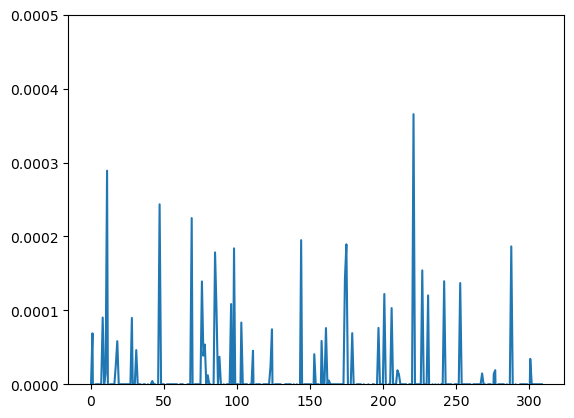

In [294]:
plt.figure()
plt.ylim([0,0.0005])
plt.plot(cond1d_some)

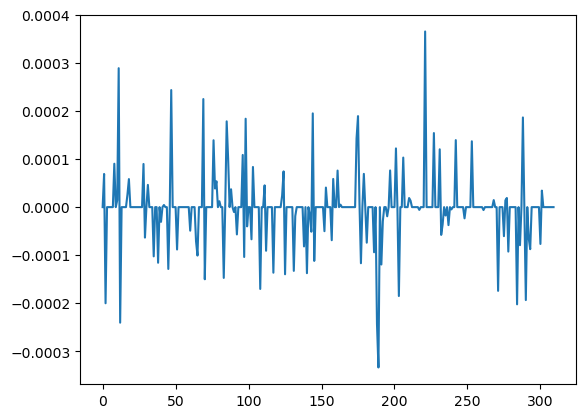

In [281]:
plt.plot(cond1d_some)

In [277]:
concat_pos_inf = []
for i in concat_top_ten_idx:
    concat_pos_inf.append(seq[i])
    
concat_pos_inf
    

['G', 'D', 'E', 'T', 'L', 'M', 'L', 'F', 'I', 'R']

In [254]:
pf[0][nzix][26:][ind]

array([11,  5, 16,  3, 13,  9, 15, 19, 16, 14], dtype=int32)

In [296]:
def reluprime(x):
    return np.where(x > 0, x, 0.0)

In [297]:
relu_cv = reluprime(cond1d_some)

In [299]:
relu_cv_norm = (relu_cv - np.min(relu_cv))/(np.max(relu_cv) - np.min(relu_cv))

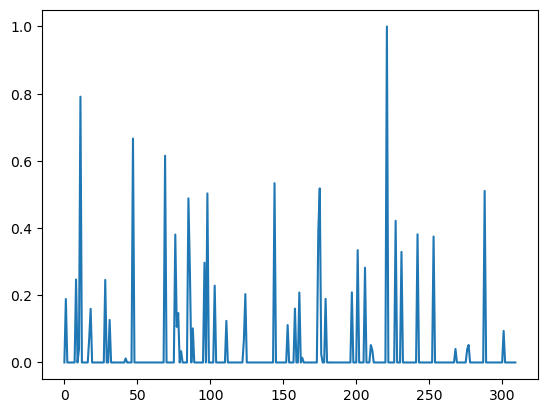

In [300]:
plt.plot(relu_cv_norm
        )

In [301]:
overall = np.concatenate([cond1d_some, cond1d_some1, cond1d_some2, cond1d_some3, cond1d_some4])

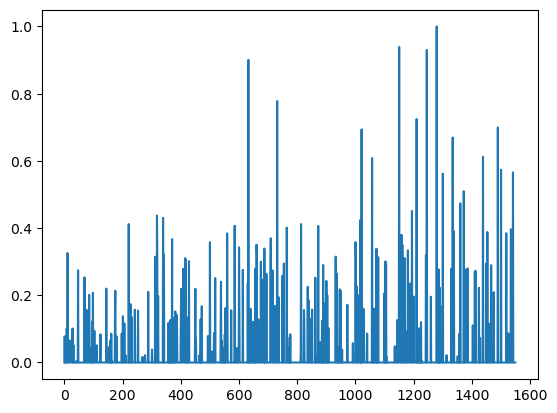

In [304]:
overall_relu = reluprime(overall)
overall_relu_norm = (overall_relu - np.min(overall_relu))/(np.max(overall_relu) - np.min(overall_relu))
plt.plot(overall_relu_norm)

In [203]:
pos_cv = np.nonzero(relu_cv)

In [221]:
pos_cv_inf_ls = list(pos_cv[0])

In [226]:
seq = pstr.split(':')[1]

In [246]:
pos_inf_list = []
for i in ind:
    pos_inf_list.append(seq[i])
    

In [247]:
pos_inf_list

['M', 'F', 'R', 'L', 'T', 'C', 'E', 'G', 'R', 'D']

In [257]:
pos_inf_list5 = []
for i in ind5:
    pos_inf_list5.append(seq[i])
    

In [259]:
cv = cond1d_some.reshape((len(cond1d_some1), 1))
cv1 = cond1d_some1.reshape((len(cond1d_some1), 1))
cv2 = cond1d_some2.reshape((len(cond1d_some1), 1))
cv3 = cond1d_some3.reshape((len(cond1d_some1), 1))
cv4 = cond1d_some4.reshape((len(cond1d_some1), 1))
mcv = mean_conv_sc.reshape((len(cond1d_some1), 1))

In [151]:
cvp1 = model_conv1d_layer1(data)[0][0].numpy()
cvp2 = model_conv1d_layer2(data)[0][0].numpy()
cvp3 = model_conv1d_layer3(data)[0][0].numpy()
cvp4 = model_conv1d_layer4(data)[0][0].numpy()
cvp5 = model_conv1d_layer5(data)[0][0].numpy()

In [168]:
np.max(mcvp1[nzix][26:])

0.016086426